In [1]:
from pathlib import Path
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from sklearn.preprocessing import MinMaxScaler
import cvxpy as cp
import pickle

snare_path = Path(r'X:\Snares')

Create list of paths to wav files

In [2]:
wav_paths = []  # Contains a list of paths to snare drum wav files
for dirName, subdirName, fileList in os.walk(snare_path):
    if not subdirName:
        for wav in fileList:
            wav_paths.append(dirName + '\\' + wav)


Load the wav files and analyze them for some basic properties

In [3]:
sample_rates = []
lengths = []
max_amplitudes = []
max_amplitude_idx = []


for i in range(len(wav_paths)):
    if not wav_paths[i].endswith('.wav'):
        print('no .wav at {}, continuing'.format(wav_paths[i]))
        continue
    data, sr = librosa.load(wav_paths[i])
    lengths.append(len(data))
    sample_rates.append(sr)
    max_amplitude = max(data, key=abs)
    max_amplitudes.append(abs(max_amplitude))
    max_amplitude_idx.append(np.where(data == max_amplitude)[0][0])


All the sample rates are 22050

1


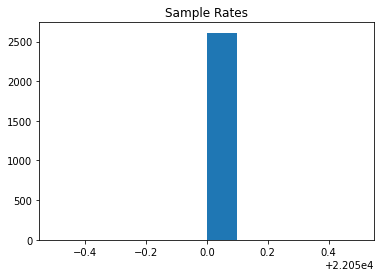

In [4]:
print(len(set(sample_rates)))
plt.hist(sample_rates);
plt.title('Sample Rates');

A vast majority of the samples are less than a second long. Truncation and padding should be fine

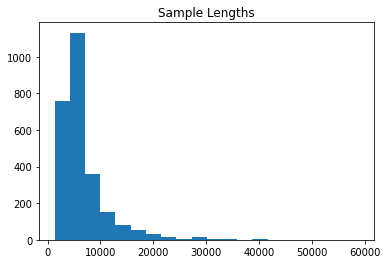

In [5]:
plt.hist(lengths, bins=20);
plt.title('Sample Lengths');

The max amplitudes of the samples are pretty disparate. Maybe it would be worth normalizing? I guess

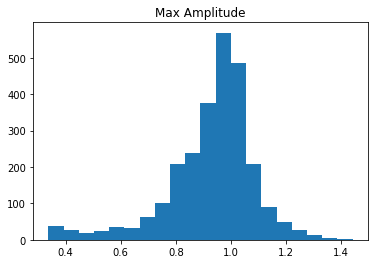

In [6]:
plt.hist(max_amplitudes, bins=20);
plt.title('Max Amplitude');

Text(0, 0.5, 'Number of Samples')

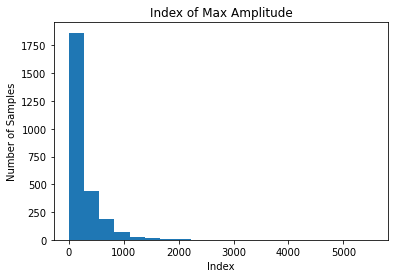

In [7]:
plt.hist(max_amplitude_idx, bins=20)
plt.title('Index of Max Amplitude');
plt.xlabel('Index')
plt.ylabel('Number of Samples')

Concatenate all the samples into a big matrix

In [8]:
def create_samples_tensor(wav_paths, align = 1000):
    '''
    creates a (num samples) x 22050 matrix containing all samples, normalized and padded / truncated to length 22050 (1 second)
    '''
    all_samples = np.empty((len(wav_paths), 22050))
    scaler = MinMaxScaler(feature_range = (-1, 1))

    for i in range(len(wav_paths)):
        data, _ = np.array(librosa.load(wav_paths[i]))

        # Align strikes

        # Find max amplitude
        max_amplitude = max(data, key=abs)
        idx = np.where(data == max_amplitude)[0][0]  # Index of max amplitude

        # Shift max amplitude to alignment point
        dist = align - idx
        if dist > 0:
            zero_pad = np.zeros(dist)
            data = np.concatenate((zero_pad, data), axis=0)
        elif dist < 0:
            data = np.delete(data, range(abs(dist)), axis=0)

        if data.shape[0] < 22050:
            zero_pad = np.zeros(22050 - data.shape[0])
            data = np.concatenate((data, zero_pad), axis=0)
        elif data.shape[0] > 22050:
            data = data[:22050]

        # Normalize
        data = data / max(data.max(), data.min(), key=abs)

        all_samples[i,:] = data
    
    return all_samples

samples_tensor = create_samples_tensor(wav_paths, 2000)


In [9]:
# Save samples_tensor
path = Path.cwd()
np.save('samples_tensor.npy', samples_tensor)

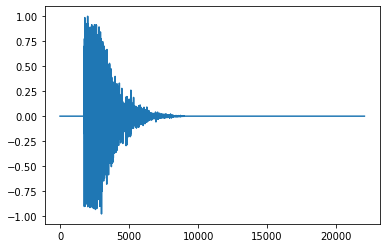

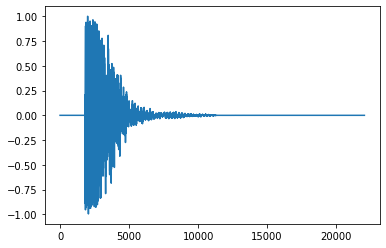

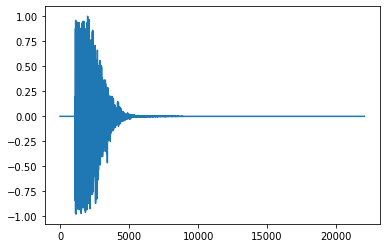

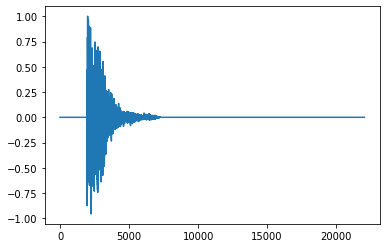

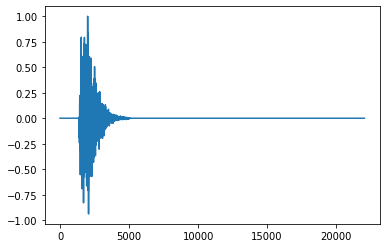

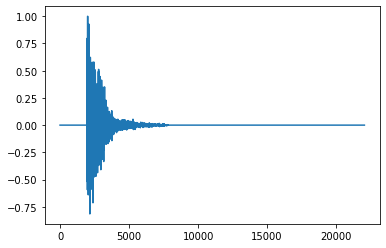

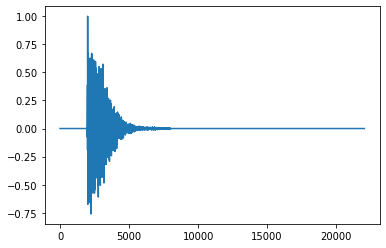

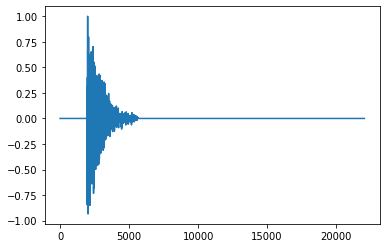

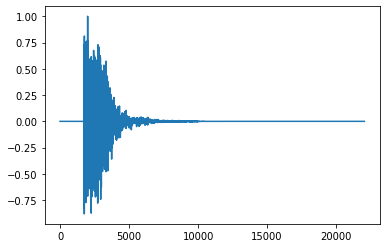

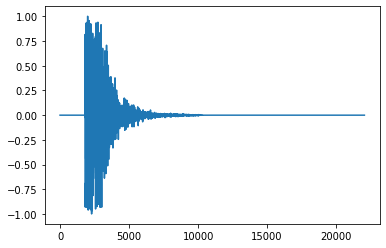

In [10]:
for i in range(1000,1010):
    plt.figure()
    plt.plot(samples_tensor[i])

Find exemplars,

https://github.com/rnithin1/exemplar-selection/blob/master/Exemplar%20Selection.ipynb

In [11]:
# Formulate SOCP problem
n = samples_tensor.T.shape[1]
X = samples_tensor.T.astype(np.double)

kappa = cp.Variable()
kappas = [cp.Variable() for _ in range(n)]
W = cp.Variable((n, n))

soc_constraints = []
soc_constraints.append(kappa == 1)
soc_constraints.append(sum(kappas) <= kappa)
soc_constraints.extend([cp.SOC(kappas[i], W.T[i]) for i in range(n)])

obj = cp.Minimize(cp.norm(X - X @ W.T, 'fro'))
prob = cp.Problem(obj, [kappa == 1] +
                       [sum(kappas) <= kappa] +
                       [cp.SOC(kappas[i], W.T[i]) for i in range(n)] )

prob.solve()

SyntaxError: invalid syntax (<ipython-input-11-3811073324e0>, line 17)

In [113]:
W.value